In [1]:
from benchmarks import BenchmarkRunner

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [ ]:
#agents = ["Deepseek_R1_1B_Qwen", "Deepseek_R1_7B_Qwen", "Deepseek_R1_8B_Llama", 
          #"Qwen_1B", "Qwen_3B", "Qwen_7B", "Qwen_1B_Instruct", "Qwen_3B_Instruct", 
          #"Qwen_7B_Instruct", "Centaur_8B", "gpt4o", "gpt40-mini"]

agents = ["Deepseek_R1_1B_Qwen", "Qwen_1B"]

rounds = [i for i in range(2, 4)]
quadrants = [2, 3]

# Optionally set your API keys; leave as None to use local (unsloth or transformers) pipelines.
openai_api_key = None  # e.g., "sk-..."
anthropic_api_key = None  # e.g., "anthropic-..."

# Create an instance of the BenchmarkRunner
benchmark = BenchmarkRunner(
    agents=agents,
    rounds=rounds,
    quadrants=quadrants,
    n_simulations=5,
    n_runs=1,
    num_cues=1,
    device="cuda:0",
    verbose=False,
    openai_api_key=openai_api_key,
    anthropic_api_key=anthropic_api_key,
    use_unsloth=True  # Set to False if you wish to use only API-based agents.
)

# Run all benchmarks and save the results
results = benchmark.multiple_benchmarks() # Results shape is (n_agents, n_rounds, n_quadrants, n_runs)
benchmark.save_results("bench.pkl")

Running benchmark for agent: Deepseek_R1_1B_Qwen
Using unsloth with GPU
==((====))==  Unsloth 2025.2.5: Fast Qwen2 patching. Transformers: 4.48.3.
   \\   /|    GPU: NVIDIA GeForce RTX 4090. Max memory: 23.621 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post2. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Device set to use cuda:0
100%|██████████| 5/5 [00:00<00:00, 11.75it/s]


Running benchmark for agent: Qwen_1B
Using unsloth with GPU
==((====))==  Unsloth 2025.2.5: Fast Qwen2 patching. Transformers: 4.48.3.
   \\   /|    GPU: NVIDIA GeForce RTX 4090. Max memory: 23.621 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post2. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Device set to use cuda:0
100%|██████████| 5/5 [00:00<00:00, 11.90it/s]

Total elapsed time: 17.21 seconds
Results saved to bench.pkl


In [40]:
import pickle
import numpy as np

filename1, filename2 = "results.pkl", "results_openai1.pkl"
with open(filename1, "rb") as file:
    results = pickle.load(file)
with open(filename2, "rb") as file:
    results_openai = pickle.load(file)
    
aggregated_results = np.zeros((12, 4, 2, 5))
aggregated_results[:10] = results
aggregated_results[10:] = results_openai[:2]

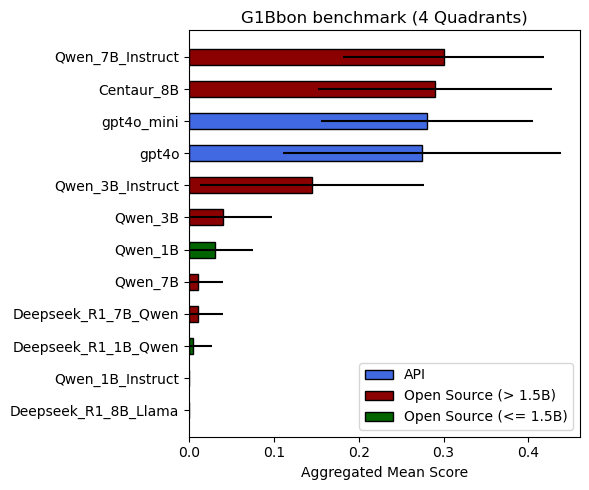

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

model_means = aggregated_results.mean(axis=(1, 3))[:, 1]
model_stds  = aggregated_results.std(axis=(1, 3))[:, 1]

model_names = [
    "Deepseek_R1_1B_Qwen",
    "Deepseek_R1_7B_Qwen",
    "Deepseek_R1_8B_Llama",
    "Qwen_1B",
    "Qwen_3B",
    "Qwen_7B",
    "Qwen_1B_Instruct",
    "Qwen_3B_Instruct",
    "Qwen_7B_Instruct",
    "Centaur_8B",
    "gpt4o",
    "gpt4o_mini",
]

# ----------------------------------------------------
# 1) Sort the data from largest mean to smallest mean
# ----------------------------------------------------
sorted_indices = np.argsort(model_means)[::-1]  # descending order
sorted_means = model_means[sorted_indices]
sorted_stds  = model_stds[sorted_indices]
sorted_names = [model_names[i] for i in sorted_indices]

# ----------------------------------------------------
# 2) Categorize each model so we can color them
# ----------------------------------------------------
model_category = {
    "Deepseek_R1_1B_Qwen":     "Open Source (<= 1.5B)",
    "Deepseek_R1_7B_Qwen":     "Open Source (> 1.5B)",
    "Deepseek_R1_8B_Llama":    "Open Source (> 1.5B)",
    "Qwen_1B":                 "Open Source (<= 1.5B)",
    "Qwen_3B":                 "Open Source (> 1.5B)",
    "Qwen_7B":                 "Open Source (> 1.5B)",
    "Qwen_1B_Instruct":        "Open Source (<= 1.5B)",
    "Qwen_3B_Instruct":        "Open Source (> 1.5B)",
    "Qwen_7B_Instruct":        "Open Source (> 1.5B)",
    "Centaur_8B":              "Open Source (> 1.5B)",
    "gpt4o":                   "API",
    "gpt4o_mini":              "API",
}

category_colors = {
    "API":                   "royalblue",
    "Open Source (> 1.5B)":    "darkred",
    "Open Source (<= 1.5B)":   "darkgreen"
}

plt.figure(figsize=(6, 5))
y_positions = np.arange(len(sorted_means))  # positions for each bar

# Build list of colors based on category
bar_colors = [category_colors[model_category[name]] for name in sorted_names]

# ----------------------------------------------------
# 3) Prepare asymmetric error bars so that the left error
#    does not push below 0.
#    For each model, if (mean - std) < 0, then use mean as the lower error.
# ----------------------------------------------------
lower_errors = np.where(sorted_means - sorted_stds < 0, sorted_means, sorted_stds)
upper_errors = sorted_stds  # always full std on the right side

# ----------------------------------------------------
# 4) Plot the horizontal bar chart with slimmer bars (height=0.5)
#    and the asymmetric error bars.
# ----------------------------------------------------
plt.barh(
    y_positions,
    sorted_means,
    height=0.5,  # slimmer bars
    xerr=[lower_errors, upper_errors],
    color=bar_colors,
    edgecolor='black',
    capsize=0
)

plt.yticks(ticks=y_positions, labels=sorted_names)
plt.gca().invert_yaxis()  # best model on top
plt.subplots_adjust(left=0.32)
plt.xlabel("Aggregated Mean Score")
plt.title("G1Bbon benchmark (4 Quadrants)")

# ----------------------------------------------------
# 5) Create a legend for the categories.
# ----------------------------------------------------
legend_handles = [
    Patch(facecolor='royalblue',  label='API',                   edgecolor='black'),
    Patch(facecolor='darkred',     label='Open Source (> 1.5B)',    edgecolor='black'),
    Patch(facecolor='darkgreen',   label='Open Source (<= 1.5B)',   edgecolor='black'),
]
plt.legend(handles=legend_handles, loc="lower right")

plt.tight_layout()
plt.show()